In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/content/drive/MyDrive/DataSets for Google Colab/Alcohol_Sales.csv', index_col = 'DATE', parse_dates = True)
df.index.freq = 'MS'

In [5]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [6]:
df.columns = ['Sales']

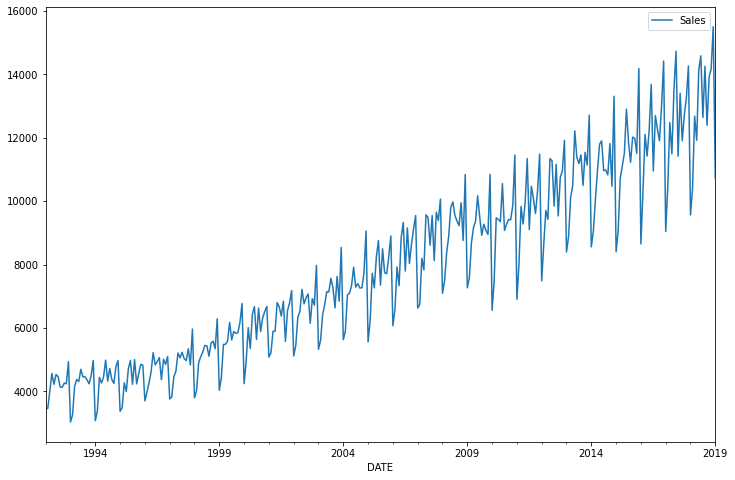

In [7]:
df.plot(figsize = (12,8))

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
results = seasonal_decompose(df['Sales'])

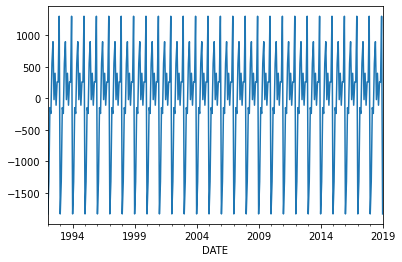

In [10]:
results.seasonal.plot()

In [11]:
#train test split
train = df[:313]
test = df[313:]

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [15]:
scaler.transform(train) #finds max value in the training data

array([[0.03658432],
       [0.03649885],
       [0.08299855],
       [0.13103684],
       [0.1017181 ],
       [0.12804513],
       [0.12266006],
       [0.09453799],
       [0.09359774],
       [0.10496624],
       [0.10334217],
       [0.16283443],
       [0.        ],
       [0.0196598 ],
       [0.09650397],
       [0.11505257],
       [0.10906915],
       [0.14231986],
       [0.12197624],
       [0.12189076],
       [0.11394136],
       [0.10300026],
       [0.12556629],
       [0.16608257],
       [0.00376101],
       [0.02957518],
       [0.12069408],
       [0.10513719],
       [0.12214719],
       [0.16702282],
       [0.11052227],
       [0.14428584],
       [0.11479614],
       [0.10402599],
       [0.14984187],
       [0.16582614],
       [0.02897684],
       [0.03872126],
       [0.10582101],
       [0.08231473],
       [0.14394393],
       [0.16608257],
       [0.10188905],
       [0.16830498],
       [0.10291478],
       [0.13018207],
       [0.15556885],
       [0.153

In [16]:
 scaled_train = scaler.transform(train) #divides by max value
 scaled_test = scaler.transform(test)

In [17]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
n_input = 2
n_features = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

In [19]:
generator[0]

(array([[[0.03658432],
         [0.03649885]]]), array([[0.08299855]]))

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [21]:
n_input = 12
n_features = 1

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

In [22]:
model = Sequential()
model.add(LSTM(150, activation = 'relu', input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit_generator(train_generator, epochs = 25)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
301/301 [==============================] - 4s 8ms/step - loss: 0.0253
Epoch 2/25
301/301 [==============================] - 3s 9ms/step - loss: 0.0072
Epoch 3/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0094
Epoch 4/25
301/301 [==============================] - 3s 9ms/step - loss: 0.0069
Epoch 5/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0060
Epoch 6/25
301/301 [==============================] - 3s 10ms/step - loss: 0.0045
Epoch 7/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0044
Epoch 8/25
301/301 [==============================] - 3s 9ms/step - loss: 0.0029
Epoch 9/25
301/301 [==============================] - 3s 9ms/step - loss: 0.0021
Epoch 10/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0024
Epoch 11/25
301/301 [==============================] - 3s 9ms/step - loss: 0.0033
Epoch 12/25
301/301 [==============================] - 3s 8ms/step - loss: 0.0020
Epoch 13/25
301/301 [===

In [26]:
model.history.history.keys()

dict_keys(['loss'])

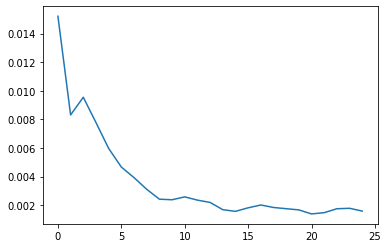

In [27]:
plt.plot(range(len(model.history.history['loss'])), model.history.history['loss'])

In [28]:
first_eval_batch = scaled_train[-12:]

In [29]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [30]:
model.predict(first_eval_batch)

array([[0.70234376]], dtype=float32)

Forecast using RNN

In [31]:
test_predictions = []
#last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]

#reahape this to the format RNN wants (same input as TimeSeriesGenerator)
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [32]:
#how far into the future will I forecast?
#len(test) for now
for i in range(len(test)):
  #one timestep ahead of historical 12 points
  current_pred = model.predict(current_batch)[0]
  #store that prediction
  test_predictions.append(current_pred)
  #update current batch to include prediction
  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1) #dropping one value from the current batch and append the new prediction

In [33]:
true_predictions = scaler.inverse_transform(test_predictions)

In [34]:
true_predictions

array([[11247.71967071],
       [12829.81524366],
       [12139.46807331],
       [14210.81291628],
       [15095.37060928],
       [11987.9380939 ],
       [13878.69933885],
       [12338.98306918],
       [13273.55635917],
       [13782.12194479],
       [14643.72264194],
       [10185.79090869]])

In [35]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
model.save('mycoolmodel.h5')

In [37]:
from keras.models import load_model

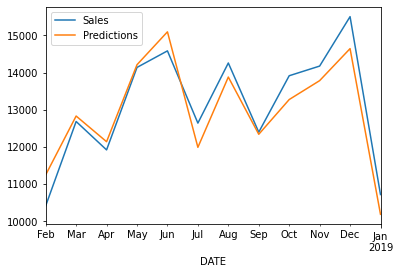

In [38]:
test.plot()